In [1]:
# --- Importing libraries and creating import/export funcitons ------------------
import pandas as pd
import numpy as np
import winsound
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LogisticRegression as LRC
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import BaggingClassifier as BAG
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from mlxtend.classifier import EnsembleVoteClassifier as EVC
from sklearn import metrics
from sklearn.model_selection import train_test_split

# --- Matplotlib Settings -------------------------------------------------------
matplotlib.rc('figure', facecolor='k')
style.use('dark_background')

# --- Pandas Display Settings ---------------------------------------------------
pd.options.display.width = 113
pd.options.display.max_columns = 100
pd.options.display.colheader_justify='right'

# --- Importing Pickles from pre_ensmbles notebook ------------------------------
def IMPORT_PICKLE(name):
    '''
    Returns pickled object within current file directory
    '''
    file_name = 'pickles/{}.pkl'.format(name)
    with open(file_name, 'rb') as my_file:
        return pickle.load(my_file)

# Datasets
X_u = IMPORT_PICKLE('unscaled_dataset')
X_n = IMPORT_PICKLE('normalized_dataset')
X_m = IMPORT_PICKLE('minmax_dataset')
y = IMPORT_PICKLE('y')

# Other
feature_names = IMPORT_PICKLE('feature_names')
ordi_dicts = IMPORT_PICKLE('ordinal_dicts') # helps in decoding ordinals
set_names = IMPORT_PICKLE('names')
clf_sets = IMPORT_PICKLE('best_clfs')
cmatrix = IMPORT_PICKLE('matrices') # confusion matrix elements of all classifiers

## 1. Finding ROC thresholds for each Classifier
---
### Definitions
- `optimal`: closest to ideal classifier (TPR=1 and FPR=0)
- `min cost`: yields minimum custom cost
- `default`: default threshold
- `max tpr @ min fpr`: yields maximum TPR possible given FPR is minimum
- `min fpr @ max tpr`: yields minimum FPR possible given TPR is maximum

SX_sig_n
Missing default threshold was rectified for SX_sig_n


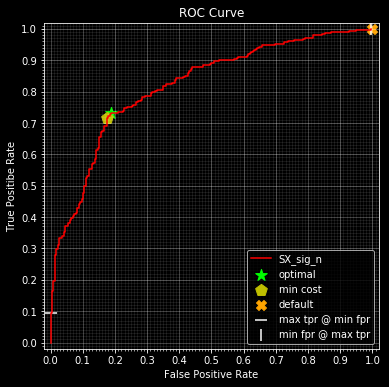

+ve range: 0.918 to 1.053 | 532
-ve range: 0.907 to 1.027 | 218
number of unique thresholds: 750


,count,mean,std,min,25%,50%,75%,max
distance,750,0.6106,0.1989,0.3281,0.4294,0.5938,0.7778,1
threshold,750,0.9957,0.02156,0.9068,0.9819,0.9985,1.011,1.053
tpr,750,0.592,0.3024,0,0.3369,0.6419,0.8755,1
fpr,750,0.2733,0.2826,0,0.0367,0.1514,0.4404,0.9954
FP,750,59.58,61.6,0,8,33,96,217
FN,750,217.1,160.9,0,66.25,190.5,352.8,532
TP,750,314.9,160.9,0,179.2,341.5,465.8,532
TN,750,158.4,61.6,1,122,185,210,218
cost,750,-515,185.7,-1086,-547,-439.5,-390,-341
accuracy,750,0.6311,0.1486,0.2907,0.5187,0.702,0.7587,0.7853


,description,distance,threshold,tpr,fpr,FP,FN,TP,TN,cost,accuracy
0,default,1,0.9068,1,1,218,0,532,0,-1090,0.7093
1,optimal,0.3281,0.9939,0.7312,0.1881,41,143,389,177,-348,0.7547
2,min cost,0.3331,0.9952,0.7162,0.1743,38,151,381,180,-341,0.748
3,max tpr @ min fpr,0.906,1.027,0.09398,0,0,482,50,218,-482,0.3573
4,min fpr @ max tpr,0.9954,0.9068,1,0.9954,217,0,532,1,-1085,0.7107


In [2]:
# --- Find Threshold Routine and Sample Output ----------------------------------
def FIND_THRESHOLDS(clf_name, clf, X_train, y_train, expt=False, show=False):
    '''
    [Description]
    -----------------------------------------------------------------------------
    Computes ROC curve of a binary classifier and identifies unique thresholds 
    such as:
    > the default threshold
    > the optimal threshold
    > the threshold yielding minimal cost
    > the threshold yielding max tpr at min fpr
    > the threshold yielding min fpr at max tpr
    
    [Inputs]
    -----------------------------------------------------------------------------
    ________
    clf_name|   [string]
                Name of the classifier
    ________
    clf     |   [sklearn classifier object]
                The classifier object. Must have either predict_proba() or
                decision_function() method
    ________
    X_train |   [numpy array]
                The training/validation data for the classifier. Used to compute
                thresholds with the predict_proba() or decision_funciton() method
    ________
    y_train |   [numpy array]
                The training/validation label for the classifier. Used to compute
                the confusion metrix at each unique threshold
    ________
    expt    |   [boolean] Default = False
                Wether to use the predict_proba() method or not. If false then
                decision_function() method is used to compute thresholds
    ________
    show    |   [boolean] Default = False
                Wether to plot the ROC curve (with important thresholds marked)
                and to show threshold ranges for the +ve and -ve class
                
    [Outputs]
    -----------------------------------------------------------------------------
    ________
    IT      |   [pandas DataFrame]
                Contains only important thresholds' data
    ________
    roc     |   [pandas DataFrame]
                Contains all thresholds' data. Useful for assessing summary stats
    '''
    
    if expt == False:
        prob_train = clf.predict_proba(X_train)[:, 1].tolist()
    else:
        prob_train = clf.decision_function(X_train).tolist()
    
    pred_probs = pd.Series(data=prob_train)
    
    # Stores unique thresholds
    probs = pred_probs.unique().tolist()
    probs.sort()
    
    # Stores threshold data: distance, tpr, fpr, confusion matrix, cost, accuracy
    roc_curve_vals = []
    
    # IT: Important Thresholds
    IT = []
    
    # Default threshold criterias
    cm = pd.DataFrame(metrics.confusion_matrix(y_train,
                                               clf.predict(X_train)),
                      columns = ['pred -ve', 'pred +ve'],
                      index = ['actual -ve', 'actual +ve'])
    dcTP = cm.loc['actual +ve', 'pred +ve']
    dcTN = cm.loc['actual -ve', 'pred -ve']
    dcFN = cm.loc['actual +ve', 'pred -ve']
    dcFP = cm.loc['actual -ve', 'pred +ve']
    
    # Computing data for each unique thrshold
    for threshold in probs:
        
        # Shifting the threshold in predictions
        thresholded_y_pred = np.where(pred_probs.values > threshold, 1, 0)
        
        # Computing the confusion matrix of the new predictions
        cm = pd.DataFrame(metrics.confusion_matrix(y_train, thresholded_y_pred),
                          columns = ['pred -ve', 'pred +ve'],
                          index = ['actual -ve', 'actual +ve'])
        TP = cm.loc['actual +ve', 'pred +ve'] # True positive
        TN = cm.loc['actual -ve', 'pred -ve'] # True negative
        FN = cm.loc['actual +ve', 'pred -ve'] # False negative
        FP = cm.loc['actual -ve', 'pred +ve'] # False positive
        
        TPR = TP/float(TP+FN) # True positive rate
        FPR = FP/float(FP+TN) # False negative rate
        
        # Distance from best possible classifier (Pythagoras' theorem)
        d = ((1-TPR)**2 + FPR**2) ** 0.5
        
        # Custom cost fuction (negated as convetion dictates it)
        cost = -1*((FP*5)+FN)
        
        # Accuracy
        ACC = (TP+TN)/float(len(y_train))
        
        # Appending results
        roc_curve_vals.append([d, threshold, TPR, FPR, FP, FN, TP, TN, cost, ACC])
        
        # Checking if the current threshold is the default thrshold
        if (TP==dcTP) & (TN==dcTN) & (FN==dcFN) & (FP==dcFP):
            
            # If true, save to IT
            IT.append(['default', d, threshold, TPR, FPR,
                       FP, FN, TP, TN, cost, ACC])
    
    # Checking for possible default threshold duplicates
    if len(IT) > 1:
        print 'Decuplicate default thresholds found in {}'.format(clf_name)
        # Checking if thresholds are probabilities or scores
        if expt == False:
            # If score then the default threshold is the one closest to 0
            IT = IT.iloc[IT['threshold'].abs().argsort()[:1]]
        else:
            # If probs then the default threshold is the one closest to 0.5
            IT = IT.iloc[(IT['threshold']-0.5).abs().argsort()[:1]]
    elif len(IT) == 0:
        print 'Missing default threshold was rectified for {}'.format(clf_name)
        for threshold in probs:
        
            # Shifting the threshold in predictions
            thresholded_y_pred = np.where(pred_probs.values >= threshold, 1, 0)

            # Computing the confusion matrix of the new predictions
            cm = pd.DataFrame(metrics.confusion_matrix(y_train, thresholded_y_pred),
                              columns = ['pred -ve', 'pred +ve'],
                              index = ['actual -ve', 'actual +ve'])
            TP = cm.loc['actual +ve', 'pred +ve'] # True positive
            TN = cm.loc['actual -ve', 'pred -ve'] # True negative
            FN = cm.loc['actual +ve', 'pred -ve'] # False negative
            FP = cm.loc['actual -ve', 'pred +ve'] # False positive

            TPR = TP/float(TP+FN) # True positive rate
            FPR = FP/float(FP+TN) # False negative rate

            # Distance from best possible classifier (Pythagoras' theorem)
            d = ((1-TPR)**2 + FPR**2) ** 0.5

            # Custom cost fuction (negated as convetion dictates it)
            cost = -1*((FP*5)+FN)

            # Accuracy
            ACC = (TP+TN)/float(len(y_train))

            # Checking if the current threshold is the default thrshold
            if (TP==dcTP) & (TN==dcTN) & (FN==dcFN) & (FP==dcFP):

                # If true, save to IT
                IT.append(['default', d, threshold, TPR, FPR,
                           FP, FN, TP, TN, cost, ACC])
    
    # Turning roc_curve_vals data into a dataframe with proper column names
    roc = pd.DataFrame(data=roc_curve_vals,
                       columns=['distance','threshold', 'tpr', 'fpr',
                                'FP', 'FN', 'TP', 'TN', 'cost', 'accuracy'])
    
    # Finding optimal threshold (minimum distance to best classifier)
    optimal = roc.sort_values(['distance']).iloc[:1].values.tolist()
    IT.append(['optimal']+optimal[0])
    
    # Finding threshold at which cost function is minimal
    min_cost = roc.sort_values(['cost'], ascending=False).iloc[:1].values.tolist()
    IT.append(['min cost']+min_cost[0])
    
    # Finding threshold at which TPR is max when FPR is min
    fpr = roc['fpr'].values.tolist()
    max_tpr = roc[roc['fpr']==min(fpr)].sort_values(['tpr'], ascending=False).iloc[:1].values.tolist()
    IT.append(['max tpr @ min fpr']+max_tpr[0])
    
    # Finding threshols at which FPR is min when TPR is max
    tpr = roc['tpr'].values.tolist()
    min_fpr = roc[roc['tpr']==max(tpr)].sort_values(['fpr']).iloc[:1].values.tolist()
    IT.append(['min fpr @ max tpr']+min_fpr[0])
    
    # Turning IT data into a dataframe with proper column names
    IT = pd.DataFrame(data=IT, columns=['description', 'distance', 'threshold', 
                                        'tpr', 'fpr', 'FP', 'FN', 'TP', 'TN', 
                                        'cost', 'accuracy'])
    
    if show:
        
        # Plotting ROC curve with important thresholds plotted onto it
        fig = plt.figure(figsize=[6, 6])
        ax = fig.add_subplot(111)
        plt.plot(fpr, tpr, c='r', label=clf_name) # Classifier ROC Curve
        plt.scatter(IT[IT['description']=='optimal'].values.tolist()[0][4],
                    IT[IT['description']=='optimal'].values.tolist()[0][3],
                    marker='*', s=150, color='lime', label = 'optimal')
        plt.scatter(IT[IT['description']=='min cost'].values.tolist()[0][4],
                    IT[IT['description']=='min cost'].values.tolist()[0][3],
                    marker='p', s=150, color='y', label = 'min cost')
        plt.scatter(IT[IT['description']=='default'].values.tolist()[0][4],
                    IT[IT['description']=='default'].values.tolist()[0][3],
                    marker='X', s=100, color='orange', label = 'default')
        plt.scatter(IT[IT['description']=='max tpr @ min fpr'].values.tolist()[0][4],
                    IT[IT['description']=='max tpr @ min fpr'].values.tolist()[0][3],
                    marker='_', s=150, color='w', label = 'max tpr @ min fpr')
        plt.scatter(IT[IT['description']=='min fpr @ max tpr'].values.tolist()[0][4],
                    IT[IT['description']=='min fpr @ max tpr'].values.tolist()[0][3],
                    marker='|', s=150, color='w', label = 'min fpr @ max tpr')
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        ax.yaxis.set_minor_locator(AutoMinorLocator(10))
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.grid(which='major', alpha=0.3)
        plt.grid(which='minor', alpha=0.1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positibe Rate')
        plt.title('ROC Curve')
        max_TPR = IT[IT['description']=='max tpr @ min fpr'].values.tolist()[0][3]
        min_FPR = IT[IT['description']=='min fpr @ max tpr'].values.tolist()[0][4]
        plt.xlim([-0.02, round(min_FPR+0.05, 1)+0.02])
        plt.ylim([round(max_TPR-0.05, 1)-0.02, 1.02])
        plt.legend(loc=4)
        plt.show()
        
        # Printing threshold ranges for the +ve class and -ve class
        label = pd.Series(data=y_train)
        prob_label = pd.concat([label, pred_probs], axis=1, ignore_index=True)
        prob_label.columns = ['label', 'prob']
        pos = prob_label[prob_label['label']==1].iloc[:,1].sort_values()
        neg = prob_label[prob_label['label']==0].iloc[:,1].sort_values()
        pos_count = pos.value_counts().sort_index()
        neg_count = neg.value_counts().sort_index()
        pos = pos.values.tolist()
        neg = neg.values.tolist()
        n_pos = len(pos_count)
        n_neg = len(neg_count)
        print '+ve range: {:.3f} to {:.3f} | {}'.format(min(pos), max(pos), n_pos)
        print '-ve range: {:.3f} to {:.3f} | {}'.format(min(neg), max(neg), n_neg)
    
    return IT, roc

# Sample Output
set_ = 3
n = 6
X_train, X_test, y_train, y_test = train_test_split(X_n, y, random_state=2018)
clf = clf_sets[set_][n]
clf_name  = clf_sets[set_].index[n]
print clf_name
res, roc = FIND_THRESHOLDS(clf_name, clf, X_train, y_train, expt=True, show=True)

pd.options.display.float_format = '{:.4g}'.format
print 'number of unique thresholds:', len(roc['threshold'].values.tolist())
display(roc.describe().T)
display(res)

In [6]:
# --- Assessing all Classifiers at Important Thresholds Individually ------------

def TEST_THRESHOLD(clf, threshold, X_test, y_test, expt=False):
    '''
    [Description]
    -----------------------------------------------------------------------------
    Computes True Positive Rate, False Positive Rate, confusion matrix elemets,
    custom cost and accuracy of a trained classifier for a specified threshold 
    using the hold-out set
    
    [Inputs]
    -----------------------------------------------------------------------------
    _________
    clf      |  [sklearn classifier object]
                The classifier object. Must have either predict_proba() or
                decision_function() method
    _________
    threshold|  [float]
                The threshold value to shift predictions with
    _________
    X_test   |  [numpy array]
                Hold-out set feature data to test classifier with
    _________
    y_test   |  [numpy array]
                Hold-out set lebals to use to assess validity of predictions with
    ________
    expt    |   [boolean] Default = False
                Wether to use the predict_proba() method or not. If false then
                decision_function() method is used to compute thresholds
    [Outputs]
    -----------------------------------------------------------------------------
    ________
    res     |   [list]
                List containing the following in this order:
                > Custom cost score
                > Accuracy
                > True Positive Rate
                > False Positive Rate
                > Number of FP
                > Number of FN
                > Number of TP
                > Number of TN
    '''
    
    # Obtaining predition probabilities/scores
    if expt == False:
        prob_train = clf.predict_proba(X_test)[:, 1].tolist()
    else:
        prob_train = clf.decision_function(X_test).tolist()
    pred_probs = pd.Series(data=prob_train)
    
    # Shifting the threshold in predictions
    thresholded_y_pred = np.where(pred_probs.values > threshold, 1, 0)
        
    # Computing the confusion matrix of the new thresholded predictions
    cm = pd.DataFrame(metrics.confusion_matrix(y_test, thresholded_y_pred),
                      columns = ['pred -ve', 'pred +ve'],
                      index = ['actual -ve', 'actual +ve'])
    TP = cm.loc['actual +ve', 'pred +ve'] # True positive
    TN = cm.loc['actual -ve', 'pred -ve'] # True negative
    FN = cm.loc['actual +ve', 'pred -ve'] # False negative
    FP = cm.loc['actual -ve', 'pred +ve'] # False positive
    TPR = TP/float(TP+FN) # True positive rate
    FPR = FP/float(FP+TN) # False negative rate
        
    # Custom cost fuction (negated as convetion dictates it)
    cost = -1*((FP*5)+FN)
        
    # Accuracy
    ACC = (TP+TN)/float(len(y_test))
    
    # Results
    res = [cost, ACC, TPR, FPR, FP, FN, TP, TN]
    
    return res

# Threshold search results (cost and accuracy scores based on train set)
TH_find_res = []

# Important thresholds test results
IT_test_res = []

# Classifier names
names = []

# Classifier name + threshold name
clf_threshold_names = []

for i in range(0, len(clf_sets)):
    
    # Feature scaling requirements for each group of classifiers
    if i < 4:
        X = X_n # Normalized scaling
    elif i < 8:
        X = X_m # MinMax scaling
    else:
        X = X_u # Unscaled features
    
    # Creating training and testing features and labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2018)
    
    for j in range(0, len(clf_sets[i])):
        
        # Finding important thresholds
        clf = clf_sets[i][j]
        name = '{}_{}{}'.format(clf_sets[i].index[j], 
                                set_names[i][0:4], 
                                set_names[i][6:])
        names.append(name)
        if name[0:1] in ('D', 'R', 'E'): # DT, RFC & ETC have only predict_proba
            IT, roc = FIND_THRESHOLDS(name, clf, X_train, y_train, expt=False)
        else:
            IT, roc = FIND_THRESHOLDS(name, clf, X_train, y_train, expt=True)
        TH_find_res.append([IT, roc]) # Saving for future referece
        
        # Computing number of unique thresholds
        n_thres = len(roc['threshold'].values.tolist()) # bad when low
        
        # Important threshold names
        IT_names = ['def', # default threshold 
                    'opt', # optimal threshold
                    'min', # min cost
                    'tpr', # max tpr @ min fpr
                    'fpr'] # min fpr @ max tpr
        
        # Assessing performance of each individual threshold
        thresholds = IT['threshold'].values.tolist()
        for k, threshold in enumerate(thresholds):
            if name[0:1] in ('D', 'R', 'E'):
                res = TEST_THRESHOLD(clf, threshold, X_test, y_test, expt=False)
            else:
                res = TEST_THRESHOLD(clf, threshold, X_test, y_test, expt=True)
                
            # Constructing the names
            clf_threshold_names.append('{}_{}'.format(name, IT_names[k]))
            
            # Appending testing results 
            IT_test_res.append(res)

TH_find_res = pd.DataFrame(data=TH_find_res, columns=['IT', 'roc'], index=names)
IT_test_res = pd.DataFrame(data=IT_test_res, index=clf_threshold_names,
                           columns=['cost', 'accuracy', 'tpr', 'fpr',
                                    'FP', 'FN', 'TP', 'TN'])

# Displaying summaries
print '\n>>> Statistical summary of thresholds:'
print IT_test_res.describe().T

winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

Missing default threshold was rectified for SX_sig_n_imb_roc
Missing default threshold was rectified for SX_sig_m_imb_roc
Missing default threshold was rectified for GB_exp_u_bal_cus
Missing default threshold was rectified for RB_gin_u_imb_roc

>>> Statistical summary of thresholds:
          count   mean    std   min    25%    50%    75%  max
cost        800 -218.8  86.21  -410 -252.2   -175   -161 -140
accuracy    800 0.6127 0.1285 0.328  0.584  0.676  0.696 0.76
tpr         800 0.6052 0.3142     0 0.4807 0.6726 0.8512    1
fpr         800 0.3719 0.3159     0 0.1707 0.3049 0.5366    1
FP          800  30.49   25.9     0     14     25     44   82
FN          800  66.33  52.78     0     25     55  87.25  168
TP          800  101.7  52.78     0  80.75    113    143  168
TN          800  51.51   25.9     0     38     57     68   82


In [48]:
# --- Best Stand Alone Models' Results ------------------------------------------
print '>>> Top 5 with max accuracy then min cost then max tpr:'
print IT_test_res.sort_values(['accuracy', 'cost', 'tpr'], 
                              ascending=[False, False, False]).head(10)

# Storing threhsolds and confidence scoring methods for each classifier
# Harvesting the thresholds
thresholds = []
for i in range(0, len(TH_find_res)):
    thresholds.append(TH_find_res.iloc[i,0].iloc[:,2].values.tolist()) 
thresholds = pd.DataFrame(data=thresholds, index=TH_find_res.index.tolist(),
                          columns=['def', 'opt', 'min', 'tpr', 'fpr'])
index = thresholds.index.tolist()

# Harvesting classifiers from clf_sets
clfs = []
for i in range(0, len(clf_sets)):
    for j in range(0, len(clf_sets[i])):
        clfs.append(clf_sets[i][j])
clfs = pd.DataFrame(data=clfs, columns=['classifier'], index=index)

# Identifying the confidence scoring methods
method = []
for i in index:
    if i[:1] in ('G', 'L', 'S'):
        method.append('decision_funtion')
    else:
        method.append('predict_proba')
method = pd.DataFrame(data=method, columns=['method'], index=index)

# Final Dataframe containing both the confidence scoring method and thresholds
METH = pd.concat([method, thresholds, clfs], axis=1)

>>> Top 5 with max accuracy then min cost then max tpr:
                      cost  accuracy    tpr    fpr  FP  FN   TP  TN
SL_l2s_n_imb_roc_def  -212      0.76  0.869 0.4634  38  22  146  44
LR_l2s_m_imb_roc_def  -228      0.76 0.8929 0.5122  42  18  150  40
LR_l2l_m_imb_roc_def  -228      0.76 0.8929 0.5122  42  18  150  40
LR_nwt_m_imb_roc_def  -228      0.76 0.8929 0.5122  42  18  150  40
LR_lbf_m_imb_roc_def  -228      0.76 0.8929 0.5122  42  18  150  40
LR_sag_m_imb_roc_def  -228      0.76 0.8929 0.5122  42  18  150  40
LR_sag_m_imb_cus_def  -213     0.756 0.8631 0.4634  38  23  145  44
LR_l1s_m_imb_roc_def  -217     0.756  0.869 0.4756  39  22  146  43
LR_l1l_m_imb_roc_def  -217     0.756  0.869 0.4756  39  22  146  43
SL_l1s_n_imb_roc_def  -225     0.756  0.881    0.5  41  20  148  41


In [144]:
# --- Threshold Voting Helper Function ------------------------------------------
def THRESHOLD_VOTING(clf, thresholds, method, X_test, y_test):
    '''
    [Description]
    -----------------------------------------------------------------------------
    Conducts a hard voting routine on the same classifier at various (ROC) 
    thresholds. Number of thresholds must be odd therefore ties are assumed to be
    impossible.
    '''
    # Getting confidence scores
    if method == 'predict_proba':
        conf_scores = clf.predict_proba(X_test)[:, 1].tolist()
    else:
        conf_scores = clf.decision_function(X_test).tolist()
    conf_scores = pd.Series(data=conf_scores)
        
    # Getting prediction sets for each threshold
    pred_sets = []
    for threshold in thresholds:
        thresholded_y_pred = np.where(conf_scores.values > threshold, 1, 0)
        pred_sets.append(thresholded_y_pred.tolist())
    pred_sets = pd.DataFrame(data=pred_sets)
    pred_sets = pred_sets.T
    pred_sets.columns = ['def', 'opt', 'min', 'tpr', 'fpr']
    
    # Summing all predictions for each row
    pred_sets['sum'] = pred_sets.sum(axis=1)
    
    # Generating verdicts
    sums = pred_sets['sum'].values.tolist()
    pred_sets['V2'] = [1 if s > 1 else 0 for s in sums] # +ve if at least 2 +ve
    pred_sets['V3'] = [1 if s > 2 else 0 for s in sums] # +ve if at least 3 +ve
    pred_sets['V4'] = [1 if s > 3 else 0 for s in sums] # +ve if at least 4 +ve
    
    return pred_sets

# Sample case
me = METH['method'][0] # Method
th = METH.iloc[0,1:-1].values.tolist() # Thresholds
clf = METH['classifier'][0] # Trained classifier object
X_train, X_test, y_train, y_test = train_test_split(X_n, y, random_state=2018)

print clf
print th
print me

SCTR = THRESHOLD_VOTING(clf, th, me, X_test, y_test)
print SCTR.head()

LinearSVC(C=0.03321495337607938, class_weight='balanced', dual=False,
     fit_intercept=False, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l1', random_state=2018,
     tol=0.0001, verbose=0)
[-0.0027807332864267092, -0.1425517556169695, 0.20895454834625446, 0.6514328961039345, -1.0709525044337047]
decision_funtion
   def  opt  min  tpr  fpr  sum  V2  V3  V4
0    1    1    1    0    1    4   1   1   1
1    1    1    1    1    1    5   1   1   1
2    0    0    0    0    1    1   0   0   0
3    1    1    0    0    1    3   1   1   0
4    0    0    0    0    1    1   0   0   0


In [214]:
# --- Hard Voting Ensemble 1 ----------------------------------------------------

# Stores results of hard voting ensemble 1
HVE1 = pd.DataFrame(columns=['Vx', 'distance', 'cost', 'accuracy', 'fpr', 'tpr', 
                             'classifier'])

# Stores verdicts for hard voting ensemble 1
VER1 = []

# Training and test sets
X_train_n, X_test_n, y_train, y_test = train_test_split(X_n, y, random_state=2018)
X_train_m, X_test_m, y_train, y_test = train_test_split(X_m, y, random_state=2018)
X_train_u, X_test_u, y_train, y_test = train_test_split(X_u, y, random_state=2018)

# Iterating through each clf in METH
for i, name in enumerate(METH.index):
    
    # Feature scaling requirements for each set of classifiers
    if name[7] == 'n': # Normalized scaling
        X_train = X_train_n; X_test = X_test_n
    elif name[7] == 'm': # MinMax scaling
        X_train = X_train_m; X_test = X_test_m
    else: # Unscaled features
        X_train = X_train_u; X_test = X_test_u
    
    me = METH['method'][i] # Method
    th = METH.iloc[i,1:-1].values.tolist() # Thresholds
    clf = METH['classifier'][i] # Trained classifier object
     
    # Getting verdicts
    verdicts = THRESHOLD_VOTING(clf, th, me, X_test, y_test)
    VER1.append(verdicts)
    
    # Minimum required number of +ve votes to classify as +ve
    n_pos_votes = ['V2','V3','V4']
     
    # Generating performance metrics
    for pos_votes in n_pos_votes:
        y_pred = verdicts[pos_votes].tolist()
        cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                          columns = ['pred -ve', 'pred +ve'],
                          index = ['actual -ve', 'actual +ve'])
        TP = cm.loc['actual +ve', 'pred +ve']
        TN = cm.loc['actual -ve', 'pred -ve']
        FN = cm.loc['actual +ve', 'pred -ve']
        FP = cm.loc['actual -ve', 'pred +ve']
        FPR = FP/float(FP+TN)
        TPR = TP/float(TP+FN)
        cost = -1*((FP*5)+FN)
        acc = (TP+TN)/float(TP+TN+FP+FN)
        
        # Distance from best possible calssifier
        d = ((1-TPR)**2 + FPR**2) ** 0.5

        # Appending data
        res = pd.DataFrame(data=[pos_votes, d, cost, acc, FPR, TPR, clf],
                           columns=[name], index=['Vx', 'distance','cost', 'accuracy', 
                                                  'fpr', 'tpr', 'classifier']).T
        HVE1 = pd.concat([HVE1, res], axis=0)

# Creating verdicts dataframe (used in the next hard voting ensmble type)
VER1 = pd.DataFrame(data=VER1, index=METH.index, columns=['verdict'])
name = [] # Seperating VER1 classifier name and configuration names
config = []
for i in VER1.index:
    name.append(i[:8])
    config.append(i[9:])
VER1 = VER1.reset_index(drop=True)
VER1['name'] = name
VER1['config'] = config
VER1 = VER1[['name', 'config', 'verdict']]

# Printing summary
cols = ['distance','cost', 'accuracy', 'fpr', 'tpr'] 
HVE1[cols] = HVE1[cols].apply(pd.to_numeric)
print '>>> Summary\n{}\n'.format(HVE1.iloc[:,1:-1].describe().T)
print '>>> Top 10 with least distance, min cost and then best accuracy:'
print HVE1.sort_values(['distance', 'cost', 'accuracy'], 
                        ascending=[True, False, False]).head(10)

>>> Summary
          count   mean     std    min    25%    50%    75%  max
distance    480  0.506  0.1182 0.3888 0.4356  0.464 0.5244    1
cost        480 -188.4   42.78   -410   -189   -175   -164 -140
accuracy    480 0.6636 0.07169  0.328   0.64   0.68  0.704 0.76
fpr         480 0.3179  0.1536      0 0.2317 0.3049 0.3415    1
tpr         480 0.6545  0.1616      0 0.5774 0.6786 0.7262    1

>>> Top 10 with least distance, min cost and then best accuracy:
                  Vx  distance  cost  accuracy    fpr    tpr                                   classifier
SX_rbf_m_imb_cus  V3    0.3888  -163     0.732 0.2927  0.744  SVC(C=575.860892998151, cache_size=100, ...
SL_l2h_m_imb_cus  V3     0.392  -161     0.724 0.2805 0.7262  LinearSVC(C=57.57069465681547, class_wei...
SX_po2_m_bal_roc  V2    0.3928  -164     0.728 0.2927 0.7381  SVC(C=198.23168182801984, cache_size=100...
SX_po2_m_imb_roc  V3    0.3981  -168     0.728 0.3049  0.744  SVC(C=0.03321495337607938, cache_size=10...
SX_rbf_m

In [229]:
# --- Hard Voting Ensemble 2 ----------------------------------------------------

# Stores performance metrics of hard voting ensemble 2
HVE2 = pd.DataFrame(columns=['Vx', 'distance', 'cost', 'accuracy', 'fpr', 'tpr'])

# Used to store hard voting ensemble 2 verdicts
VER2 = pd.DataFrame(columns=['name', 'Vx', 'verdict'])

# Getting all classifier names
clf_unique_names = VER1['name'].unique()

for name in clf_unique_names:
    VER = VER1[VER1['name'] == name]
    for V in ('V2', 'V3', 'V4'):
        verdicts=pd.concat([VER[VER['config']=='bal_cus'].iloc[0,2][V],
                            VER[VER['config']=='bal_roc'].iloc[0,2][V],
                            VER[VER['config']=='imb_cus'].iloc[0,2][V],
                            VER[VER['config']=='imb_roc'].iloc[0,2][V]], axis=1)
        sums = verdicts.sum(axis=1).values.tolist()
        verdicts['verdict'] = [1 if s > 2 else 0 for s in sums]
        verdicts.columns = ['bal_cus', 'bal_roc', 'imb_cus', 'imb_roc', 'verdict']
        
        # Appending verdicts
        res = pd.DataFrame(data=[name, V, verdicts],
                           index=['name', 'Vx', 'verdict']).T
        VER2 = pd.concat([VER2, res], axis=0)
        
        # Computing performance metrics
        y_pred = verdicts['verdict'].tolist()
        cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                          columns = ['pred -ve', 'pred +ve'],
                          index = ['actual -ve', 'actual +ve'])
        TP = cm.loc['actual +ve', 'pred +ve']
        TN = cm.loc['actual -ve', 'pred -ve']
        FN = cm.loc['actual +ve', 'pred -ve']
        FP = cm.loc['actual -ve', 'pred +ve']
        FPR = FP/float(FP+TN)
        TPR = TP/float(TP+FN)
        cost = -1*((FP*5)+FN)
        acc = (TP+TN)/float(TP+TN+FP+FN)
        
        # Distance from best possible calssifier
        d = ((1-TPR)**2 + FPR**2) ** 0.5

        # Appending data
        res = pd.DataFrame(data=[V, d, cost, acc, FPR, TPR],
                           columns=[name], index=['Vx', 'distance','cost',
                                                  'accuracy', 'fpr', 'tpr']).T
        HVE2 = pd.concat([HVE2, res], axis=0)

# Reseting the index (just for consistency sake)
VER2.reset_index(inplace=True, drop=True)

# Printing summary
cols = ['distance','cost', 'accuracy', 'fpr', 'tpr'] 
HVE2[cols] = HVE2[cols].apply(pd.to_numeric)
print '>>> Summary\n{}\n'.format(HVE2.iloc[:,1:].describe().T)
print '>>> Top 10 with least distance, min cost and then best accuracy:'
print HVE2.sort_values(['distance', 'cost', 'accuracy'], 
                        ascending=[True, False, False]).head(10)

>>> Summary
          count   mean     std     min    25%    50%    75%    max
distance    120 0.4762 0.06422  0.3894  0.434 0.4512 0.4945 0.7563
cost        120   -175   19.96    -271   -183 -171.5 -162.5   -143
accuracy    120 0.6609 0.05199   0.464  0.635   0.68  0.696  0.744
fpr         120 0.2751 0.08047 0.09756 0.2195 0.2805 0.3293 0.5366
tpr         120 0.6297   0.108    0.25 0.5595 0.6577 0.7098 0.8571

>>> Top 10 with least distance, min cost and then best accuracy:
          Vx  distance  cost  accuracy    fpr    tpr
SX_rbf_m  V3    0.3894  -151     0.716 0.2439 0.6964
SX_rbf_m  V2    0.4004  -163     0.716 0.2805 0.7143
SX_po2_m  V2    0.4113  -174      0.72 0.3171 0.7381
SL_l2s_n  V2    0.4138  -172     0.712 0.3049 0.7202
LR_l1l_n  V2    0.4151  -175     0.716 0.3171 0.7321
LR_l1l_m  V2    0.4151  -175     0.716 0.3171 0.7321
LR_l1s_n  V2     0.417  -178      0.72 0.3293  0.744
LR_l2l_n  V3    0.4179  -157     0.692 0.2439 0.6607
LR_l2s_n  V2    0.4189  -176     0.712 0.31

In [242]:
print VER2.head()
print
print VER2.iloc[0,2].iloc[:4,4]

a = VER2[(VER2['name']=='SL_l1s_n') & (VER2['Vx']=='V2')]
print a.iloc[0,2]['verdict']

       name  Vx                                      verdict
0  SL_l1s_n  V2       bal_cus  bal_roc  imb_cus  imb_roc ...
1  SL_l1s_n  V3       bal_cus  bal_roc  imb_cus  imb_roc ...
2  SL_l1s_n  V4       bal_cus  bal_roc  imb_cus  imb_roc ...
3  SL_l2s_n  V2       bal_cus  bal_roc  imb_cus  imb_roc ...
4  SL_l2s_n  V3       bal_cus  bal_roc  imb_cus  imb_roc ...

0    1
1    1
2    0
3    1
Name: verdict, dtype: int64
0      1
1      1
2      0
3      1
4      0
5      0
6      1
7      1
8      1
9      1
10     0
11     1
12     0
13     1
14     0
15     1
16     1
17     0
18     1
19     0
20     0
21     0
22     1
23     0
24     1
25     1
26     1
27     1
28     1
29     1
      ..
220    0
221    1
222    1
223    0
224    1
225    1
226    1
227    1
228    1
229    1
230    1
231    0
232    0
233    1
234    1
235    1
236    0
237    1
238    1
239    0
240    0
241    1
242    1
243    0
244    1
245    0
246    1
247    1
248    1
249    0
Name: verdict, Length: 250, 

In [247]:
# --- Hard Voting Ensemble 3 ----------------------------------------------------

# Stores performance metrics of hard voting ensemble 2
HVE3 = pd.DataFrame(columns=['distance', 'cost', 'accuracy', 'fpr', 'tpr'])

# Used to store hard voting ensemble 2 verdicts
VER3 = pd.DataFrame(columns=['name', 'verdict'])

# Getting all classifier names
clf_unique_names = VER2['name'].unique()

for name in clf_unique_names:
    VER = VER2[VER2['name'] == name]
    verdicts=pd.concat([VER[VER['Vx']=='V2'].iloc[0,2]['verdict'],
                        VER[VER['Vx']=='V3'].iloc[0,2]['verdict'],
                        VER[VER['Vx']=='V4'].iloc[0,2]['verdict']], axis=1)
    verdicts.columns = ['V2', 'V3', 'V4']
    sums = verdicts.sum(axis=1).values.tolist()
    verdicts['verdict'] = [1 if s > 1 else 0 for s in sums]
    
    # Appending verdicts
    res = pd.DataFrame(data=[name, verdicts], index=['name', 'verdict']).T
    VER3 = pd.concat([VER3, res], axis=0)
    
    # Computing performance metrics
    y_pred = verdicts['verdict'].tolist()
    cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                      columns = ['pred -ve', 'pred +ve'],
                      index = ['actual -ve', 'actual +ve'])
    TP = cm.loc['actual +ve', 'pred +ve']
    TN = cm.loc['actual -ve', 'pred -ve']
    FN = cm.loc['actual +ve', 'pred -ve']
    FP = cm.loc['actual -ve', 'pred +ve']
    FPR = FP/float(FP+TN)
    TPR = TP/float(TP+FN)
    cost = -1*((FP*5)+FN)
    acc = (TP+TN)/float(TP+TN+FP+FN)
        
    # Distance from best possible calssifier
    d = ((1-TPR)**2 + FPR**2) ** 0.5

    # Appending data
    res = pd.DataFrame(data=[d, cost, acc, FPR, TPR], columns=[name], 
                       index=['distance', 'cost', 'accuracy', 'fpr', 'tpr']).T
    HVE3 = pd.concat([HVE3, res], axis=0)

# Reseting the index (just for consistency sake)
VER3.reset_index(inplace=True, drop=True)

# Printing summary
cols = ['distance','cost', 'accuracy', 'fpr', 'tpr'] 
HVE3[cols] = HVE3[cols].apply(pd.to_numeric)
print '>>> Summary\n{}\n'.format(HVE3.describe().T)
print '>>> Top 10 with least distance, min cost and then best accuracy:'
print HVE3.sort_values(['distance', 'cost', 'accuracy'], 
                        ascending=[True, False, False]).head(10)

>>> Summary
          count   mean     std    min    25%    50%    75%    max
distance     40 0.4538 0.03433 0.3894 0.4307 0.4473  0.469 0.5818
cost         40 -174.3    13.3   -226   -179   -171   -166   -151
accuracy     40 0.6712 0.02856  0.576  0.655  0.684  0.688  0.716
fpr          40 0.2808 0.04054 0.2195 0.2561 0.2805 0.3049 0.4146
tpr          40 0.6478 0.05147 0.5238 0.6205 0.6667 0.6845  0.744

>>> Top 10 with least distance, min cost and then best accuracy:
          distance  cost  accuracy    fpr    tpr
SX_rbf_m    0.3894  -151     0.716 0.2439 0.6964
LR_l2l_n    0.4179  -157     0.692 0.2439 0.6607
SL_l2s_m    0.4221  -168     0.696 0.2805 0.6845
LR_l1s_m    0.4261  -175       0.7 0.3049 0.7024
SL_l2h_m    0.4266  -169     0.692 0.2805 0.6786
LR_nwt_n    0.4279  -166     0.688 0.2683 0.6667
LR_lbf_n    0.4279  -166     0.688 0.2683 0.6667
LR_sag_n    0.4279  -166     0.688 0.2683 0.6667
SL_l2s_n    0.4299  -163     0.684 0.2561 0.6548
SL_l1s_m    0.4303  -173     0.692 0